# Floodplain age distribution generator

This code takes a the total area of the channel belt, lateral mobility rate (TR), and a distribution of sediment storage times (aka erosional ages) and uses a mass balance equation reported in Geyman et al. (2025) to calculate a PDF of floodplain ages.

Equation from:Geyman, E.C., Ke, Y., Magyar, J.S., Reahl, J.N., Soldano, V., Brown, N.D., West, A.J., Fischer, W.W., Lamb, M.P., 2025. Scaling laws for sediment storage and turnover in river floodplains. Sci. Adv. 11, eadu8574. https://doi.org/10.1126/sciadv.adu8574

Author: James (Huck) Rees; PhD Student, UCSB Geography

Date: May 12, 2025

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

In [5]:
def floodplain_age_distribution(t, F_t, tcb):
    return (1 / tcb) * (1 - F_t)

def process_floodplain_age(csv_path_tcb, csv_path_tfp, x_limit,
                            c_best=None, c_uncertainty=None,
                            e_best=None, e_uncertainty=None):
    try:
        tcb_data = pd.read_csv(csv_path_tcb)
        tcb_values = tcb_data.iloc[:, 0]
        tcb_mean = tcb_values.mean()
        print(f"Using mean TCB value: {tcb_mean:.2f} years")
    except Exception as e:
        print("Error loading TCB data:", e)
        return

    try:
        tfp_data = pd.read_csv(csv_path_tfp)
        tfp_values = np.sort(tfp_data.iloc[:, 0].values)
        F_empirical = np.arange(1, len(tfp_values) + 1) / len(tfp_values)
    except Exception as e:
        print("Error loading TFP data:", e)
        return

    t = np.linspace(1, x_limit, 1000)
    F_t = np.interp(t, tfp_values, F_empirical, left=0, right=1)
    g_t = floodplain_age_distribution(t, F_t, tcb_mean)
    G_t = np.cumsum(g_t) * (t[1] - t[0])

    if None not in (c_best, e_best, c_uncertainty, e_uncertainty):
        t_ka = t / 1000  # Convert years to kiloyears for observed equation
        G_obs = c_best * t_ka**e_best
        G_obs_upper = (c_best + c_uncertainty) * t_ka**(e_best + e_uncertainty)
        G_obs_lower = (c_best - c_uncertainty) * t_ka**(e_best - e_uncertainty)
    else:
        G_obs = G_obs_upper = G_obs_lower = None

    plt.figure(figsize=(18, 4))

    plt.subplot(1, 3, 1)
    plt.plot(t, F_t, label='F(t) - Empirical CDF of eroded sediment age', color='blue')
    plt.xlabel('Time (years)')
    plt.ylabel('Cumulative Probability')
    plt.title('CDF: Eroded Sediment Age')
    plt.grid(True)
    plt.legend()
    plt.xlim([0, x_limit])
    plt.ylim([0, 1])

    plt.subplot(1, 3, 2)
    plt.plot(t, g_t, label='g(t) - Floodplain age distribution', color='green')
    plt.xlabel('Time (years)')
    plt.ylabel('Probability Density')
    plt.title('PDF: Floodplain Age Distribution')
    plt.grid(True)
    plt.legend()
    plt.xlim([0, x_limit])

    plt.subplot(1, 3, 3)
    plt.plot(t, G_t, label='G(t) - CDF of floodplain age', color='orange')
    if G_obs is not None:
        plt.plot(t, G_obs, '--', label=f'Observed: y = {c_best}x^{e_best}', color='gray')
        plt.fill_between(t, G_obs_lower, G_obs_upper, color='gray', alpha=0.3, label='Observed uncertainty')
    plt.xlabel('Time (years)')
    plt.ylabel('Cumulative Probability')
    plt.title('CDF: Floodplain Age Distribution')
    plt.grid(True)
    plt.legend()
    plt.xlim([0, x_limit])
    plt.ylim([0, 1.6])

    plt.tight_layout()
    plt.show()


Using mean TCB value: 667.60 years


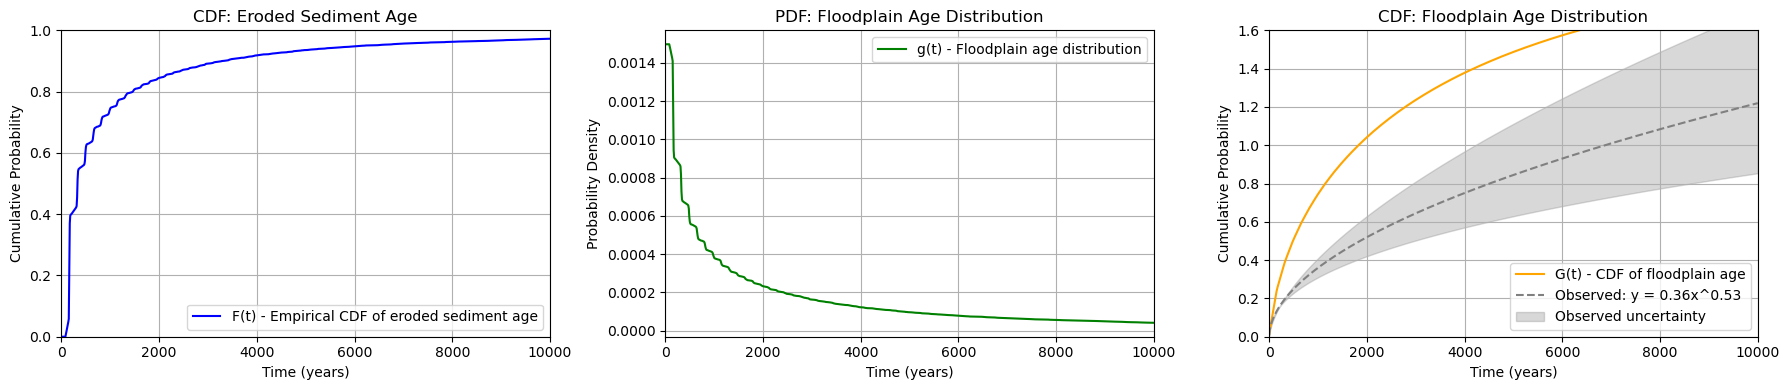

In [6]:
# Example usage:
TCB_dist_path = r"D:\Dissertation\Data\RiverMapping\Mobility\Yukon_Beaver\TCB_Distributions\Reach_1_TCB_distribution.csv"
TFP_dist_path = r"D:\Dissertation\Data\RiverMapping\Mobility\Yukon_Beaver\TFP_Distributions\Reach_1_TFP_distribution.csv"
c_best=0.36
c_uncertainty=0.05
e_best=0.53
e_uncertainty=0.09
process_floodplain_age(TCB_dist_path, TFP_dist_path, 10000, c_best, c_uncertainty, e_best, e_uncertainty)

In [11]:
def floodplain_age_distribution(t, F_t, tcb):
    return (1 / tcb) * (1 - F_t)

def plot_loglog_pdf(csv_path_tcb, csv_path_tfp, tr_value):
    try:
        tcb_data = pd.read_csv(csv_path_tcb)
        tcb_values = tcb_data.iloc[:, 0]
        tcb_mean = tcb_values.mean()
        print(f"Using mean TCB value: {tcb_mean:.2f} years")
    except Exception as e:
        print("Error loading TCB data:", e)
        return

    try:
        tfp_data = pd.read_csv(csv_path_tfp)
        tfp_values = np.sort(tfp_data.iloc[:, 0].values)
        F_empirical = np.arange(1, len(tfp_values) + 1) / len(tfp_values)
    except Exception as e:
        print("Error loading TFP data:", e)
        return

    t = np.logspace(1, 5, 1000)  # from 10 to 100,000 years
    F_t = np.interp(t, tfp_values, F_empirical, left=0, right=1)
    g_t = floodplain_age_distribution(t, F_t, tcb_mean)

    t_normalized = t / tr_value

    # Plot g(t) - floodplain age distribution
    plt.figure(figsize=(6, 5))
    plt.loglog(t_normalized, g_t, color='green', label='Floodplain age PDF (g(t))')
    plt.xlabel('Normalized Time (t / TR)')
    plt.ylabel('Probability Density')
    plt.title('Floodplain Age Distribution (Log-Log, Normalized)')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_loglog_erosion_pdf(csv_path_tfp, tr_value):
    try:
        tfp_data = pd.read_csv(csv_path_tfp)
        tfp_values = tfp_data.iloc[:, 0].values
    except Exception as e:
        print("Error loading TFP data:", e)
        return

    t = np.logspace(1, 5, 1000)
    f_t, bin_edges = np.histogram(tfp_values, bins=t, density=True)
    t_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    t_normalized = t_centers / tr_value

    plt.figure(figsize=(6, 5))
    plt.loglog(t_normalized, f_t, color='purple', label='Erosional age PDF (f(t))')
    plt.xlabel('Normalized Time (t / TR)')
    plt.ylabel('Probability Density')
    plt.title('Erosional Age Distribution (Log-Log, Normalized)')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()


Using mean TCB value: 667.60 years


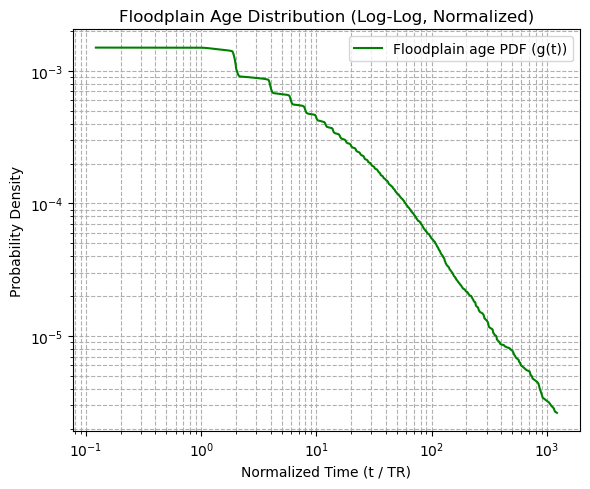

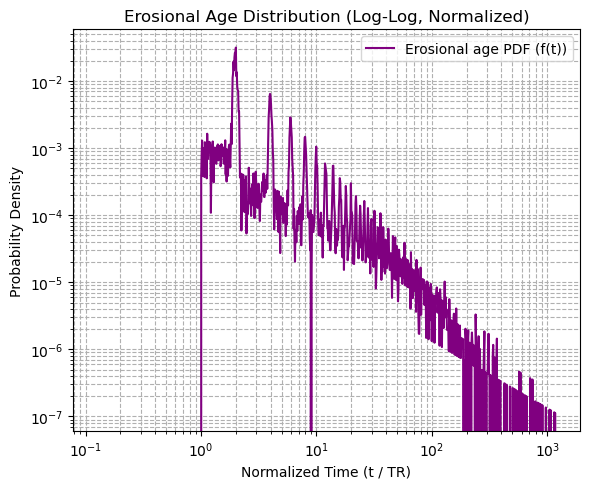

In [12]:
plot_loglog_pdf(TCB_dist_path, TFP_dist_path, tr_value = 82)
plot_loglog_erosion_pdf(TFP_dist_path, tr_value=82)

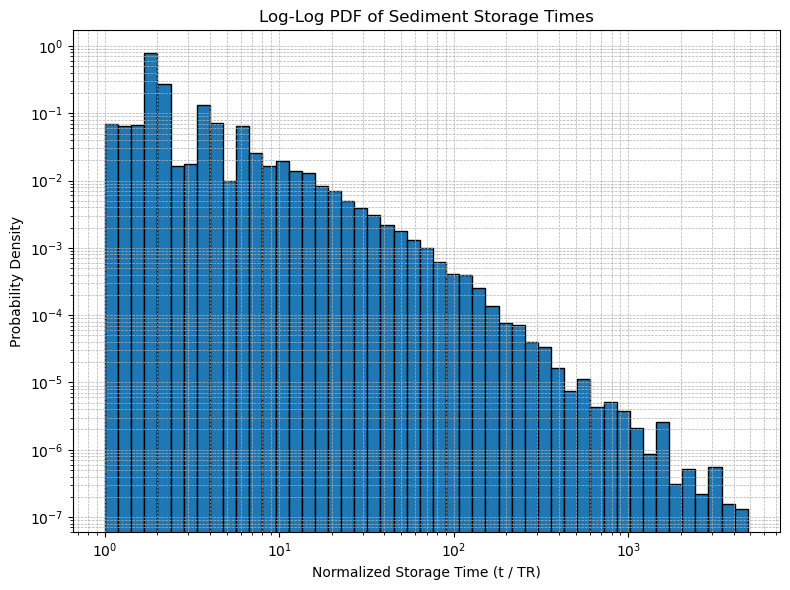

In [14]:

# === USER INPUT ===
TR = 82  # Floodplain reworking timescale in years
INPUT_CSV = r"D:\Dissertation\Data\RiverMapping\Mobility\Yukon_Beaver\TFP_Distributions\Reach_1_TFP_distribution.csv"

# === LOAD DATA ===
df = pd.read_csv(INPUT_CSV)

# Assuming the storage times are in the first column
time_data = df.iloc[:, 0].dropna().values

# Normalize time by TR
normalized_time = time_data / TR

# === PLOTTING ===
plt.figure(figsize=(8, 6))

# Plot histogram with log-log axes
counts, bins, patches = plt.hist(
    normalized_time,
    bins=np.logspace(np.log10(min(normalized_time)), np.log10(max(normalized_time)), 50),
    density=True,
    log=True,
    edgecolor='black'
)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Normalized Storage Time (t / TR)')
plt.ylabel('Probability Density')
plt.title('Log-Log PDF of Sediment Storage Times')
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()


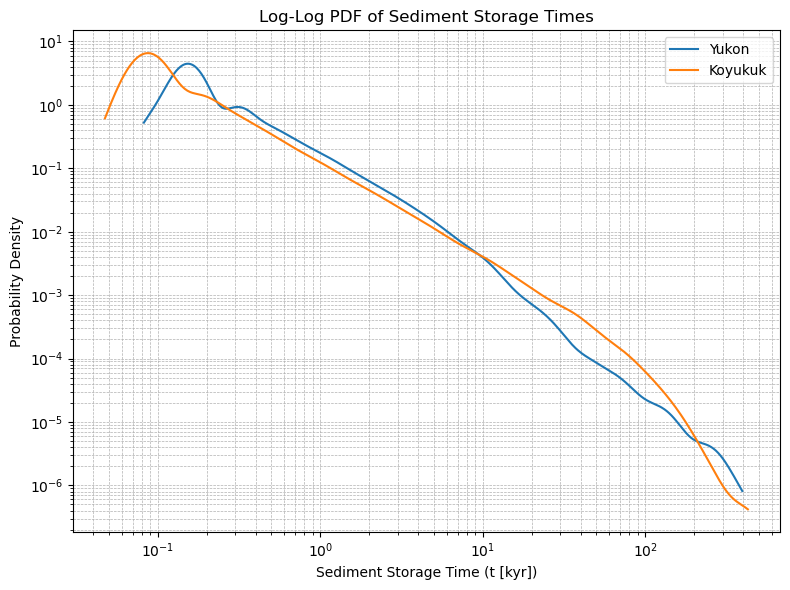

In [22]:
# === USER INPUT ===
CSV_PATH_1 = r"D:\Dissertation\Data\RiverMapping\Mobility\Yukon_Beaver\TFP_Distributions\Reach_1_TFP_distribution.csv"
CSV_PATH_2 = r"D:\Dissertation\Data\RiverMapping\Mobility\Koyukuk_Huslia\TFP_Distributions\Reach_1_TFP_distribution.csv"

# === LOAD AND PROCESS FUNCTION ===
def process_data(csv_path):
    df = pd.read_csv(csv_path)
    time_data = df.iloc[:, 0].dropna().values
    normalized_time = time_data / 1000  # Normalize by 1000 to convert to kyr
    kde = gaussian_kde(np.log10(normalized_time))
    x_vals = np.logspace(np.log10(min(normalized_time)), np.log10(max(normalized_time)), 500)
    y_vals = kde(np.log10(x_vals)) / (x_vals * np.log(10))
    return x_vals, y_vals

# === PROCESS BOTH SERIES ===
x_vals_1, y_vals_1 = process_data(CSV_PATH_1)
x_vals_2, y_vals_2 = process_data(CSV_PATH_2)

# === PLOTTING ===
plt.figure(figsize=(8, 6))

plt.plot(x_vals_1, y_vals_1, label='Yukon')
plt.plot(x_vals_2, y_vals_2, label='Koyukuk')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sediment Storage Time (t [kyr])')
plt.ylabel('Probability Density')
plt.title('Log-Log PDF of Sediment Storage Times')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



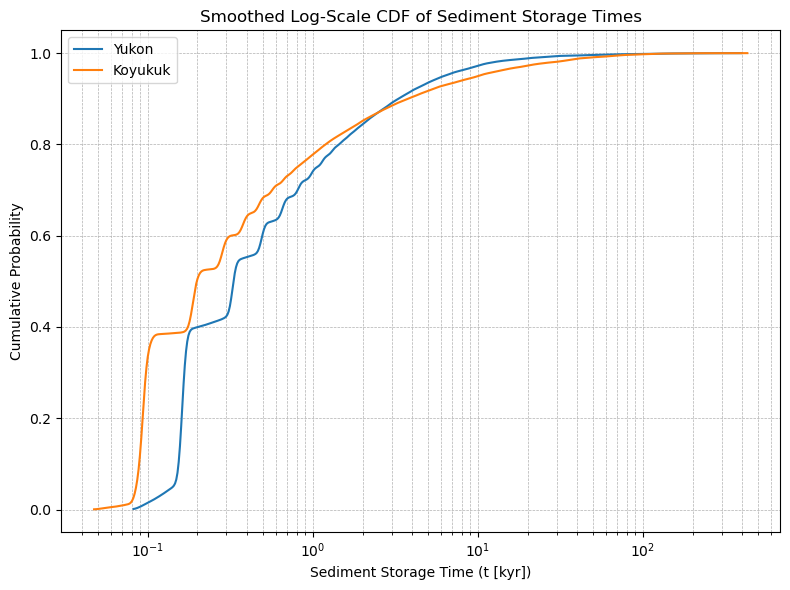

In [29]:
# === LOAD AND PROCESS FUNCTION ===
def process_cdf_data(csv_path):
    df = pd.read_csv(csv_path)
    time_data = df.iloc[:, 0].dropna().values
    normalized_time = np.sort(time_data / 1000)  # Normalize by 1000 to convert to kyr and sort
    cdf = np.arange(1, len(normalized_time) + 1) / len(normalized_time)

    # Interpolate to regular log-spaced x values
    log_x = np.logspace(np.log10(normalized_time[0]), np.log10(normalized_time[-1]), 500)
    interp_func = interp1d(normalized_time, cdf, bounds_error=False, fill_value=(0, 1))
    smoothed_cdf = gaussian_filter1d(interp_func(log_x), sigma=2)

    return log_x, smoothed_cdf

# === PROCESS BOTH SERIES ===
x_cdf_1, y_cdf_1 = process_cdf_data(CSV_PATH_1)
x_cdf_2, y_cdf_2 = process_cdf_data(CSV_PATH_2)

# === PLOTTING ===
plt.figure(figsize=(8, 6))

plt.plot(x_cdf_1, y_cdf_1, label='Yukon')
plt.plot(x_cdf_2, y_cdf_2, label='Koyukuk')
plt.xscale('log')
plt.xlabel('Sediment Storage Time (t [kyr])')
plt.ylabel('Cumulative Probability')
plt.title('Smoothed Log-Scale CDF of Sediment Storage Times')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

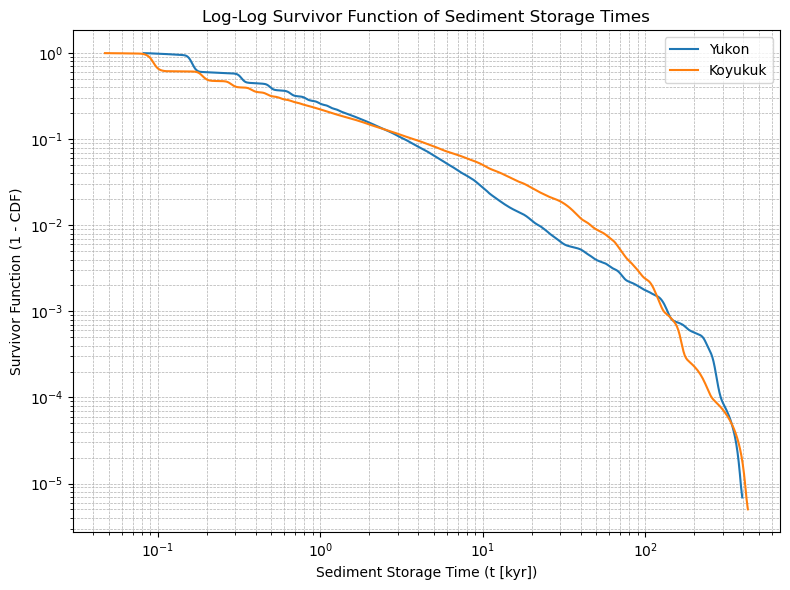

In [30]:
# === LOAD AND PROCESS FUNCTION ===
def process_survivor_data(csv_path):
    df = pd.read_csv(csv_path)
    time_data = df.iloc[:, 0].dropna().values
    normalized_time = np.sort(time_data / 1000)  # Normalize by 1000 to convert to kyr and sort
    cdf = np.arange(1, len(normalized_time) + 1) / len(normalized_time)

    # Interpolate to regular log-spaced x values
    log_x = np.logspace(np.log10(normalized_time[0]), np.log10(normalized_time[-1]), 500)
    interp_func = interp1d(normalized_time, cdf, bounds_error=False, fill_value=(0, 1))
    smoothed_cdf = gaussian_filter1d(interp_func(log_x), sigma=2)

    survivor = 1 - smoothed_cdf
    return log_x, survivor

# === PROCESS BOTH SERIES ===
x_surv_1, y_surv_1 = process_survivor_data(CSV_PATH_1)
x_surv_2, y_surv_2 = process_survivor_data(CSV_PATH_2)

# === PLOTTING ===
plt.figure(figsize=(8, 6))

plt.plot(x_surv_1, y_surv_1, label='Yukon')
plt.plot(x_surv_2, y_surv_2, label='Koyukuk')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sediment Storage Time (t [kyr])')
plt.ylabel('Survivor Function (1 - CDF)')
plt.title('Log-Log Survivor Function of Sediment Storage Times')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


C:\Users\huckr\AppData\Local\Temp\ipykernel_23148\2372122472.py:9: RuntimeWarning: invalid value encountered in power
  outer = (1 + (tau / b3)**(1/s3))**(-m3 * s3)
C:\Users\huckr\AppData\Local\Temp\ipykernel_23148\2372122472.py:9: RuntimeWarning: overflow encountered in power
  outer = (1 + (tau / b3)**(1/s3))**(-m3 * s3)
C:\Users\huckr\AppData\Local\Temp\ipykernel_23148\2372122472.py:8: RuntimeWarning: invalid value encountered in power
  inner = (1 + (tau / b2)**(1/s2))**(-m2 * s2)


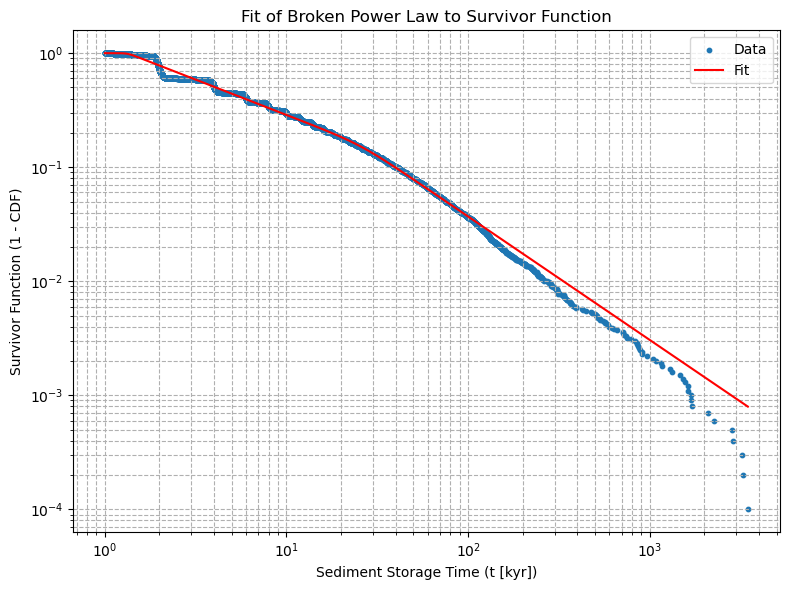

b2 = 0.0163
b3 = 0.3153
s2 = 0.0327
s3 = 0.1811
m2 = 0.6186
m3 = 0.4636


In [32]:
# === USER INPUT ===
CSV_PATH = CSV_PATH_1
TR = 82  # Timescale normalization (kyr)

# === BROKEN POWER LAW FUNCTION ===
def broken_power_law(t, b2, b3, s2, s3, m2, m3):
    tau = t / TR
    inner = (1 + (tau / b2)**(1/s2))**(-m2 * s2)
    outer = (1 + (tau / b3)**(1/s3))**(-m3 * s3)
    return inner * outer

# === LOAD AND PREPARE DATA ===
df = pd.read_csv(CSV_PATH)
time_data = df.iloc[:, 0].dropna().values / TR # Convert to normalized age
sorted_times = np.sort(time_data)
cdf = np.arange(1, len(sorted_times)+1) / len(sorted_times)
survivor = 1 - cdf

# === FITTING ===
# Filter out non-positive values for log fitting
positive_mask = (sorted_times > 0) & (survivor > 0)
t_fit = sorted_times[positive_mask]
y_fit = survivor[positive_mask]

# Initial guesses (b2, b3, s2, s3, m2, m3)
p0 = [1.0, 100.0, 0.5, 0.5, 1.0, 3.0]
popt, pcov = curve_fit(broken_power_law, t_fit, y_fit, p0=p0, maxfev=10000)

# === PLOTTING ===
plt.figure(figsize=(8, 6))
plt.scatter(t_fit, y_fit, label='Data', s=10)
plt.plot(t_fit, broken_power_law(t_fit, *popt), label='Fit', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sediment Storage Time (t [kyr])')
plt.ylabel('Survivor Function (1 - CDF)')
plt.title('Fit of Broken Power Law to Survivor Function')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

# === OUTPUT PARAMETERS ===
param_names = ['b2', 'b3', 's2', 's3', 'm2', 'm3']
for name, val in zip(param_names, popt):
    print(f"{name} = {val:.4f}")
